### Noise

In [36]:
import torch
import numpy as np
from tqdm import tqdm


from cellot.train.utils import get_free_gpu
replica_id = int(get_free_gpu())
device = torch.device(f'cuda:{replica_id}')
from cellot.models.cond_score_module import Pred_X_0_Parameterization
from cellot.data.utils import *

cuda


Using GPUs: 3


In [37]:
import wandb
run = wandb.init()
artifact = run.use_artifact('protein-optimization/sc_diff/model-ce1o3uhh:v25', type='model')
artifact_dir = artifact.download()

wandb: ERROR Control-C detected -- Run data was not synced


In [ ]:
artifact_dir

'./artifacts/model-ce1o3uhh:v25'

In [ ]:
ckpt_path = f'{artifact_dir}/model.ckpt'

In [ ]:
import hydra
with hydra.initialize('../configs/diff/'):
    config = hydra.compose(config_name='pred_x_0.yaml')

/tmp/ipykernel_2052682/1750149385.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize('../configs/diff/'):
/data/rsg/chemistry/johnyang/miniconda3/envs/cot2/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'pred_x_0.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


### Noise

In [ ]:
config.score_network.n_layers = 2

In [ ]:
config.TARGET = 'abexinostat'

In [ ]:
lm = Pred_X_0_Parameterization.load_from_checkpoint(hparams=config, checkpoint_path=ckpt_path).to(device)
print('')

2023-07-27 01:23:54,993 Created a temporary directory at /tmp/tmpdq726g27
2023-07-27 01:23:54,995 Writing /tmp/tmpdq726g27/_remote_module_non_sriptable.py


Dropout is 0.1



In [ ]:
# %%
import cellot.models
from cellot.data.cell import load_cell_data
import torch
from cellot.models.ae import AutoEncoder
from pathlib import Path

def load_data(config, **kwargs):
    data_type = config.get("data.type", "cell")
    if data_type in ["cell", "cell-merged", "tupro-cohort"]:
        loadfxn = load_cell_data

    elif data_type == "toy":
        loadfxn = load_toy_data

    else:
        raise ValueError

    return loadfxn(config, **kwargs)


def load_model(config, device, restore=None, **kwargs):
    # def load_autoencoder_model(config, restore=None, **kwargs):
    
    def load_optimizer(config, params):
        kwargs = dict(config.get("optim", {}))
        assert kwargs.pop("optimizer", "Adam") == "Adam"
        optim = torch.optim.Adam(params, **kwargs)
        return optim


    def load_networks(config, **kwargs):
        kwargs = kwargs.copy()
        kwargs.update(dict(config.get("ae", {})))
        name = kwargs.pop("name")

        # if name == "scgen":
        model = AutoEncoder

        # elif name == "cae":
        #     model = ConditionalAutoEncoder
        # else:
        #     raise ValueError

        return model(**kwargs)
    
    model = load_networks(config, **kwargs)
    optim = load_optimizer(config, model.parameters())

    if restore is not None and Path(restore).exists():
        print('Loading model from checkpoint')
        ckpt = torch.load(restore, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optim.load_state_dict(ckpt["optim_state"])
        # if config.model.name == "scgen" and "code_means" in ckpt:
        #     model.code_means = ckpt["code_means"]
            
    # logger.info(f'Model on device {next(model.parameters()).device}')

    return model, optim

def load(config, device, restore=None, include_model_kwargs=False, **kwargs):

    loader, model_kwargs = load_data(config, include_model_kwargs=True, **kwargs)

    model, opt = load_model(config, device, restore=restore, **model_kwargs)

    return model, opt, loader
# %% [markdown]
# ### Training

# %%
# restore_path = '/Mounts/rbg-storage1/users/johnyang/cellot/saved_weights/ae/ae.pt'
# ae, _ = load_model(config, 'cuda', restore=restore_path, input_dim=1000)
# autoencoder = ae.to(device)

In [ ]:
import numpy as np
from scipy.special import gamma
import torch


class LatentDiffuser:
    """VP-SDE diffuser class for translations."""

    def __init__(self, conf):
        """
        Args:
            min_b: starting value in variance schedule.
            max_b: ending value in variance schedule.
        """
        self._conf = conf
        self.min_b = conf.min_b
        self.max_b = conf.max_b
        self.schedule = conf.schedule
        self._score_scaling = conf.score_scaling
        self.latent_dim = conf.latent_dim

    def _scale(self, x):
        return x * self._conf.coordinate_scaling

    def _unscale(self, x):
        return x / self._conf.coordinate_scaling

    def b_t(self, t):
        if np.any(t < 0) or np.any(t > 1):
            raise ValueError(f'Invalid t={t}')
        if self.schedule == 'linear': 
            return self.min_b + t*(self.max_b - self.min_b)
        elif self.schedule == 'cosine':
            return self.max_b + 0.5*(self.min_b - self.max_b)*(1 + np.cos(t*np.pi))
        elif self.schedule == 'exponential':
            sigma = t * np.log10(self.max_b) + (1 - t) * np.log10(self.min_b)
            return 10 ** sigma
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')
    
    def diffusion_coef(self, t):
        """Time-dependent diffusion coefficient."""
        return np.sqrt(self.b_t(t))

    def drift_coef(self, x, t):
        """Time-dependent drift coefficient."""
        return -1/2 * self.b_t(t) * x

    def sample_ref(self, n_samples: float=1):
        return np.random.normal(size=(n_samples, self.latent_dim))

    def marginal_b_t(self, t):
        if self.schedule == 'linear':
            return t*self.min_b + (1/2)*(t**2)*(self.max_b-self.min_b)
        elif self.schedule == 'exponential': 
            return (self.max_b**t * self.min_b**(1-t) - self.min_b) / (
                np.log(self.max_b) - np.log(self.min_b))
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')

    def calc_trans_0(self, score_t, x_t, t, use_torch=True):
        beta_t = self.marginal_b_t(t)
        beta_t = beta_t[..., None, None]
        exp_fn = torch.exp if use_torch else np.exp
        cond_var = 1 - exp_fn(-beta_t)
        return (score_t * cond_var + x_t) / exp_fn(-1/2*beta_t)

    def forward(self, x_t_1: np.ndarray, t: float, num_t: int):
        """Samples marginal p(x(t) | x(t-1)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t_1 = self._scale(x_t_1)
        b_t = torch.tensor(self.marginal_b_t(t) / num_t).to(x_t_1.device)
        z_t_1 = torch.tensor(np.random.normal(size=x_t_1.shape)).to(x_t_1.device)
        x_t = torch.sqrt(1 - b_t) * x_t_1 + torch.sqrt(b_t) * z_t_1
        return x_t
    
    def distribution(self, x_t, score_t, t, mask, dt):
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        std = g_t * np.sqrt(dt)
        mu = x_t - (f_t - g_t**2 * score_t) * dt
        if mask is not None:
            mu *= mask[..., None]
        return mu, std

    def forward_marginal(self, x_0: np.ndarray, t: float):
        """Samples marginal p(x(t) | x(0)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_0 = self._scale(x_0)
        x_t = np.random.normal(
            loc=np.exp(-1/2*self.marginal_b_t(t)) * x_0,
            scale=np.sqrt(1 - np.exp(-self.marginal_b_t(t)))
        )
        score_t = self.score(x_t, x_0, t)
        x_t = self._unscale(x_t)
        return x_t, score_t

    def score_scaling(self, t: float):
        if self._score_scaling == 'var':
            return 1 / self.conditional_var(t)
        elif self._score_scaling == 'std':
            return 1 / np.sqrt(self.conditional_var(t))
        elif self._score_scaling == 'expected_norm':
            return np.sqrt(2) / (gamma(1.5) * np.sqrt(self.conditional_var(t)))
        else:
            raise ValueError(f'Unrecognized scaling {self._score_scaling}')
        
    def ode(self,
            *,
            x_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            mask: np.ndarray=None,
            noise_scale: float=1.0,
        ):
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)

        # Probability flow ODE
        perturb = (f_t - (1/2)*(g_t**2) * score_t) * dt
        
        if mask is not None:
            perturb *= mask[..., None]
        else:
            mask = np.ones(x_t.shape[:-1])
        
        # For positive dt, we add dx and vv.
        x_t_1 = x_t + perturb
        x_t_1 = self._unscale(x_t_1)
        return x_t_1
        
    def reverse(
            self,
            *,
            x_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            mask: np.ndarray=None,
            center: bool=True,
            ode: bool=False,
            noise_scale: float=1.0,
        ):
        """Simulates the reverse SDE for 1 step

        Args:
            x_t: [..., 3] current positions at time t in angstroms.
            score_t: [..., 3] rotation score at time t.
            t: continuous time in [0, 1].
            dt: continuous step size in [0, 1].
            mask: True indicates which residues to diffuse.

        Returns:
            [..., 3] positions at next step t-1.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        if ode:
            # Probability flow ODE
            perturb = (f_t - (1/2)*(g_t**2) * score_t) * dt
        else:
            # Usual stochastic dynamics
            z = noise_scale * np.random.normal(size=score_t.shape)
            perturb = (f_t - g_t**2 * score_t) * dt + g_t * np.sqrt(dt) * z

        if mask is not None:
            perturb *= mask[..., None]
        else:
            mask = np.ones(x_t.shape[:-1])
        x_t_1 = x_t - perturb
        if center:
            com = np.sum(x_t_1, axis=-2) / np.sum(mask, axis=-1)[..., None]
            x_t_1 -= com[..., None, :]
        x_t_1 = self._unscale(x_t_1)
        return x_t_1

    def conditional_var(self, t, use_torch=False):
        """Conditional variance of p(xt|x0).

        Var[x_t|x_0] = conditional_var(t)*I

        """
        if use_torch:
            return 1 - torch.exp(-self.marginal_b_t(t))
        return 1 - np.exp(-self.marginal_b_t(t))

    def score(self, x_t, x_0, t, use_torch=False, scale=False):
        if use_torch:
            exp_fn = torch.exp
        else:
            exp_fn = np.exp
        if scale:
            x_t = self._scale(x_t)
            x_0 = self._scale(x_0)
        return -(x_t - exp_fn(-1/2*self.marginal_b_t(t)) * x_0) / self.conditional_var(t, use_torch=use_torch)

In [ ]:
from cellot.utils.dev_utils import get_target_cond_idx
import numpy as np

gammas = np.logspace(1, -3, num=50)

def forward_ODE(x_t, score_t, t, dt):
    return lm.diffuser.ode(x_t=x_t.detach().cpu().numpy(), score_t=score_t.detach().cpu().numpy(), t=t, dt=dt)

def reverse_ODE(x_t, score_t, t, dt):
    return lm.diffuser.ode(x_t=x_t.detach().cpu().numpy(), score_t=score_t.detach().cpu().numpy(), t=t, dt=-dt)

def forward_diffuse_to_t(x_t, t, dt, fwd_y):
    lm.eval()
    with torch.inference_mode():
        x_t_fwd = x_t
        for fwd_t in np.arange(0 + dt, t + dt, dt):
            x_t_fwd = torch.tensor(x_t_fwd).float().to(device)
            pred_x_0 = lm.score_network((x_t_fwd, fwd_y), fwd_t)
            fwd_cond_score = lm.diffuser.score(x_t_fwd, pred_x_0, fwd_t, use_torch=True)
            x_t_fwd = forward_ODE(x_t_fwd, fwd_cond_score, fwd_t, lm.dt)
        return x_t_fwd

def reverse_diffuse_from_t(x_t, t, dt, reverse_y, second_cond=None):
    lm.eval()
    with torch.inference_mode():
        x_t_rvs = x_t
        for rvs_t in np.arange(t, 0, -dt):
            x_t_rvs = torch.tensor(x_t_rvs).float().to(device)
            pred_x_0 = lm.score_network((x_t_rvs, reverse_y), rvs_t)
            rvs_cond_score = lm.diffuser.score(x_t_rvs, pred_x_0, rvs_t, use_torch=True)
            if second_cond is not None:
                second_pred_x_0 = lm.score_network((pred_x_0, second_cond), rvs_t)
                second_cond_score = lm.diffuser.score(pred_x_0, second_pred_x_0, rvs_t, use_torch=True)
                rvs_cond_score = rvs_cond_score + second_cond_score
            x_t_rvs = reverse_ODE(x_t_rvs, rvs_cond_score, rvs_t, lm.dt)
        return x_t_rvs

def inference(lm, batch, dt=0.01, t_start=1.0, fwd_y=None, rvs_y=None, second_rvs_y=None, cond=True, ae=None, target=None):
    device = lm.device
    # assert ae is not None, 'Must provide autoencoder'
    assert target is not None or not cond, 'Must provide target'
    
    with torch.inference_mode():
        lm.eval()
        all_genes_x, y_batch = batch
        fwd_y = y_batch.to(device) if fwd_y is None else fwd_y

        # Forward ODE calculations
        diffuser_code = forward_diffuse_to_t(all_genes_x, t_start, dt, fwd_y)
        
        rvs_y_cond = torch.ones_like(y_batch) * get_target_cond_idx(target) if cond else y_batch
        rvs_y = rvs_y if rvs_y is not None else rvs_y_cond
        
        # Reverse ODE calculations
        x_0 = reverse_diffuse_from_t(diffuser_code, t_start, dt, rvs_y, second_cond=second_rvs_y)
        return x_0, diffuser_code

In [ ]:
from imp import reload
reload(cellot.utils.dev_utils)

/tmp/ipykernel_2052682/3036645331.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


<module 'cellot.utils.dev_utils' from '/Mounts/rbg-storage1/users/johnyang/cellot/cellot/utils/dev_utils.py'>

In [ ]:
# from cellot.utils.dev_utils import load_markers

# sel_mg, gene_idxs = load_markers(config)
# sel_mg

KeyboardInterrupt: 

In [ ]:
def DEV_load_ae_cell_data(
        config,
        data=None,
        split_on=None,
        return_as="loader",
        include_model_kwargs=False,
        pair_batch_on=None,
        ae=None,
        encode_latents=False,
        sel_mg=None,
        **kwargs
    ):
        assert ae is not None or not encode_latents, "ae must be provided"
        
        if isinstance(return_as, str):
            return_as = [return_as]

        assert set(return_as).issubset({"anndata", "dataset", "loader"})
        config.data.condition = config.data.get("condition", "drug")
        condition = config.data.condition
        
        data = read_single_anndata(config, **kwargs)
        
        inputs = torch.Tensor(
            data.X if not sparse.issparse(data.X) else data.X.todense()
        )

        if encode_latents:
            genes = data.var_names.to_list()
            data = anndata.AnnData(
                ae.eval().encode(inputs).detach().numpy(),
                obs=data.obs.copy(),
                uns=data.uns.copy(),
            )
            data.uns["genes"] = genes


        # cast to dense and check for nans
        if sparse.issparse(data.X):
            data.X = data.X.todense()
        assert not np.isnan(data.X).any()

        if sel_mg is not None:
            data = data[:, sel_mg]

        dataset_args = dict()
        model_kwargs = {}

        model_kwargs["input_dim"] = data.n_vars

        # if config.get("model.name") == "cae":
        condition_labels = sorted(data.obs[condition].cat.categories)
        model_kwargs["conditions"] = condition_labels
        dataset_args["obs"] = condition
        dataset_args["categories"] = condition_labels

        if "training" in config:
            pair_batch_on = config.training.get("pair_batch_on", pair_batch_on)

        # if split_on is None:
            # if config.model.name == "cellot":
            #     # datasets & dataloaders accessed as loader.train.source
        split_on = ["split", "transport"]
        if pair_batch_on is not None:
            split_on.append(pair_batch_on)

            # if (config.ae.name == "scgen" #or config.ae.name == "cae"
            #     #or config.ae.name == "popalign"):
            # split_on = ["split"]

            # else:
            #     raise ValueError

        if isinstance(split_on, str):
            split_on = [split_on]

        for key in split_on:
            assert key in data.obs.columns

        if len(split_on) > 0:
            splits = {
                (key if isinstance(key, str) else ".".join(key)): data[index]
                for key, index in data.obs[split_on].groupby(split_on).groups.items()
            }

            dataset = nest_dict(
                {
                    key: AnnDataDataset(val.copy(), **dataset_args)
                    for key, val in splits.items()
                },
                as_dot_dict=True,
            )
        else:
            dataset = AnnDataDataset(data.copy(), **dataset_args)

        if "loader" in return_as:
            kwargs = dict(config.dataloader)
            kwargs.setdefault("drop_last", True)
            loader = cast_dataset_to_loader(dataset, **kwargs)

        returns = list()
        for key in return_as:
            if key == "anndata":
                returns.append(data)

            elif key == "dataset":
                returns.append(dataset)

            elif key == "loader":
                returns.append(loader)

        if include_model_kwargs:
            returns.append(model_kwargs)

        if len(returns) == 1:
            return returns[0]

        # returns.append(data)

        return tuple(returns)

In [ ]:
datasets = DEV_load_ae_cell_data(config, return_as='dataset')#, ae=autoencoder.cpu(), encode_latents=True)#, sel_mg=sel_mg)

In [ ]:
loader = cast_dataset_to_loader(datasets, batch_size=8192, shuffle=False, drop_last=False)
loader

2023-07-27 01:27:42,971 Batch size adapted to 656 due to dataset size.


{'test': {'source': <torch.utils.data.dataloader.DataLoader at 0x7f5c08c88910>,
  'target': <torch.utils.data.dataloader.DataLoader at 0x7f5c03ad1d30>},
 'train': {'source': <torch.utils.data.dataloader.DataLoader at 0x7f5c0b6c6e80>,
  'target': <torch.utils.data.dataloader.DataLoader at 0x7f5bf9e37fa0>}}

In [ ]:
source = datasets.test.source.adata.X

In [ ]:
target = datasets.test.target.adata.X

In [ ]:
datasets.train.target.adata.obs['drug']

A01_E09_RT_BC_105_Lig_BC_154    trametinib
A01_E09_RT_BC_120_Lig_BC_309    trametinib
A01_E09_RT_BC_163_Lig_BC_317    trametinib
A01_E09_RT_BC_208_Lig_BC_39     trametinib
A01_E09_RT_BC_210_Lig_BC_123    trametinib
                                   ...    
H12_F10_RT_BC_199_Lig_BC_199    trametinib
H12_F10_RT_BC_295_Lig_BC_281    trametinib
H12_F10_RT_BC_38_Lig_BC_157     trametinib
H12_F10_RT_BC_45_Lig_BC_273     trametinib
H12_F10_RT_BC_46_Lig_BC_52      trametinib
Name: drug, Length: 2621, dtype: category
Categories (1, object): ['trametinib']

In [ ]:
from cellot.losses.mmd import mmd_distance

def compute_mmd_loss(lhs, rhs, gammas):
    return np.mean([mmd_distance(lhs, rhs, g) for g in gammas])

In [20]:
# Define list variables
gts, recons, uncond_recons, d_codes, uncond_d_codes = [], [], [], [], []

loss_list = []

# Function for inference and data gathering
def process_batch(batch):
    batch = [x.to(device) for x in batch]
    uncond_y = torch.ones_like(batch[1]) * lm.score_network.null_cond_idx
    gts.append(batch)

    # Conditioned inference
    recon, diffuser_code = inference(
        lm, batch, dt=0.1, t_start=1.0, fwd_y=batch[1], cond=False, target=None)

    # Unconditioned inference
    uncond_recon, uncond_d_code = inference(
        lm, batch, dt=0.1, t_start=1.0, fwd_y=uncond_y, cond=False, target=None)

    # Data gathering
    recons.append(recon) 
    d_codes.append(diffuser_code)
    uncond_d_codes.append(uncond_d_code)
    uncond_recons.append(uncond_recon)
    
# Process batches
# for batch in tqdm(loader.train.source):
#     process_batch(batch)

for batch in tqdm(loader.train.source):
    process_batch(batch)
    
for batch in tqdm(loader.train.target):
    process_batch(batch)

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_2052682/2219886959.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t_fwd = torch.tensor(x_t_fwd).float().to(device)
100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


In [21]:
d_codes_np = np.concatenate(d_codes, axis=0) # Assuming [B, G] shape for each array in the list

In [22]:
d_codes_np.shape

(16673, 1000)

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# d_codes_np = np.concatenate(d_codes, axis=0) # Assuming [B, G] shape for each array in the list

# Apply PCA
pca = TruncatedSVD(n_components=100)
pca.fit(d_codes_np)

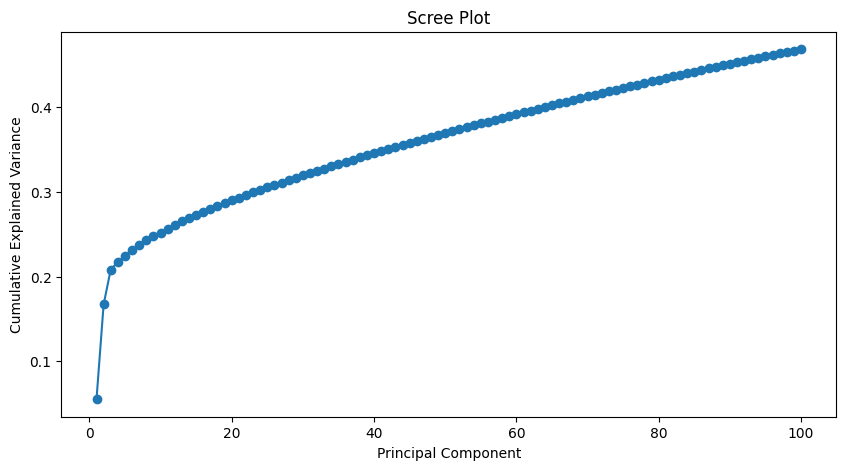

In [ ]:
# Create scree plot
plt.figure(figsize=(10,5))
plt.plot(range(1, 1000 + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [23]:
gt_labels = [b[1] for b in gts]

In [24]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

/data/rsg/chemistry/johnyang/miniconda3/envs/cot2/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/rsg/chemistry/johnyang/miniconda3/envs/cot2/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/rsg/chemistry/johnyang/miniconda3/en

In [25]:
# Assuming gts contains the ground truth labels and its length is equal to d_codes
gt_labels_np = torch.cat(gt_labels, axis=0).detach().cpu().numpy() # or you can process it according to your needs

Running UMAP with n_neighbors=5


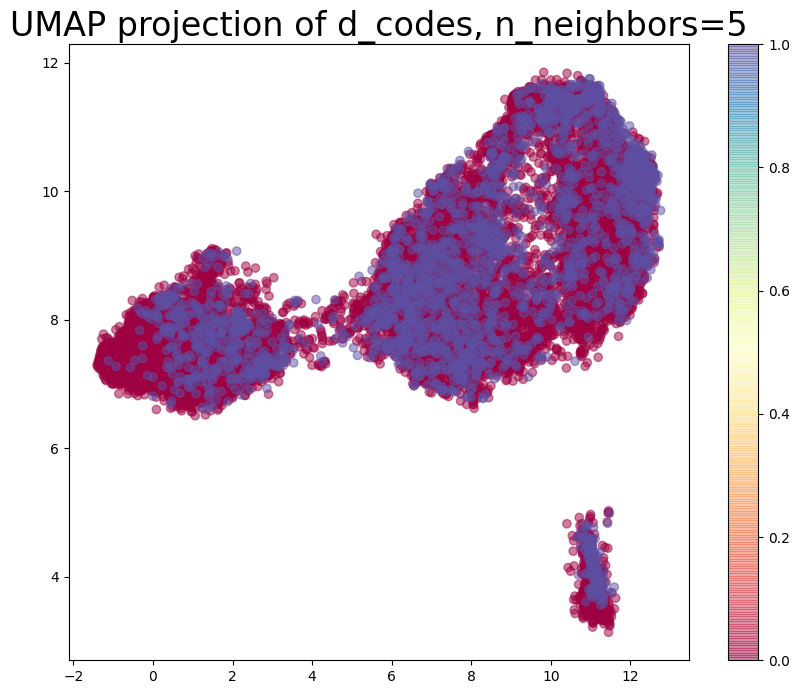

Running UMAP with n_neighbors=10


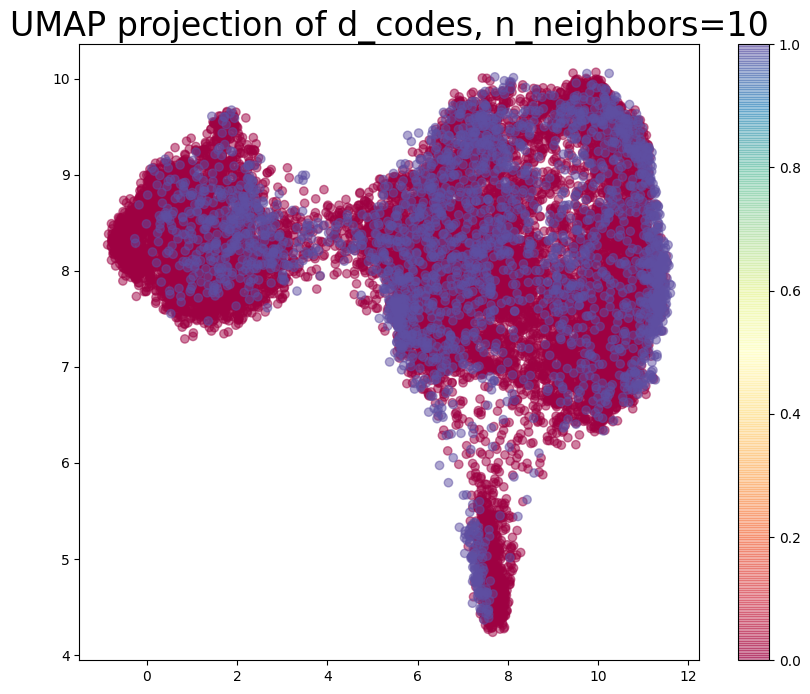

Running UMAP with n_neighbors=15


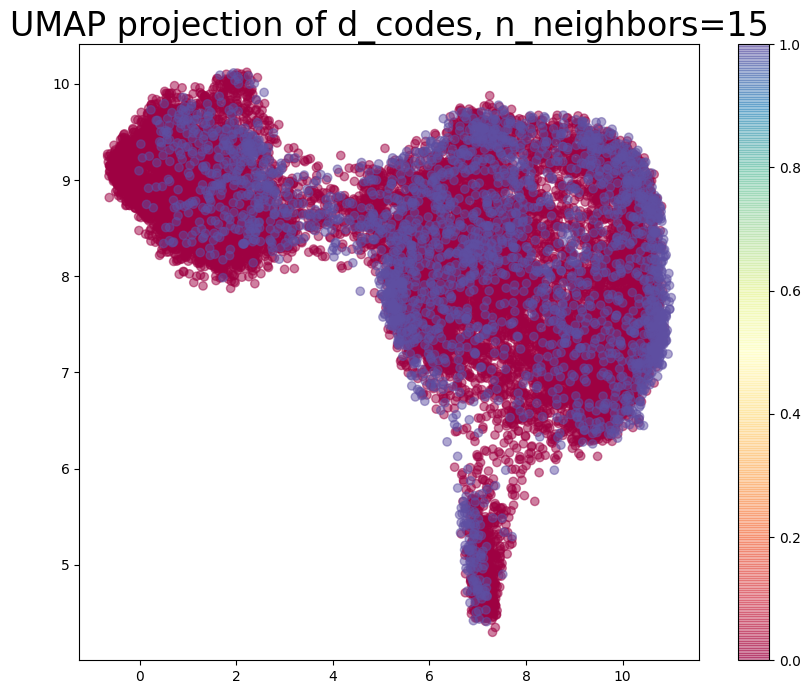

Running UMAP with n_neighbors=20


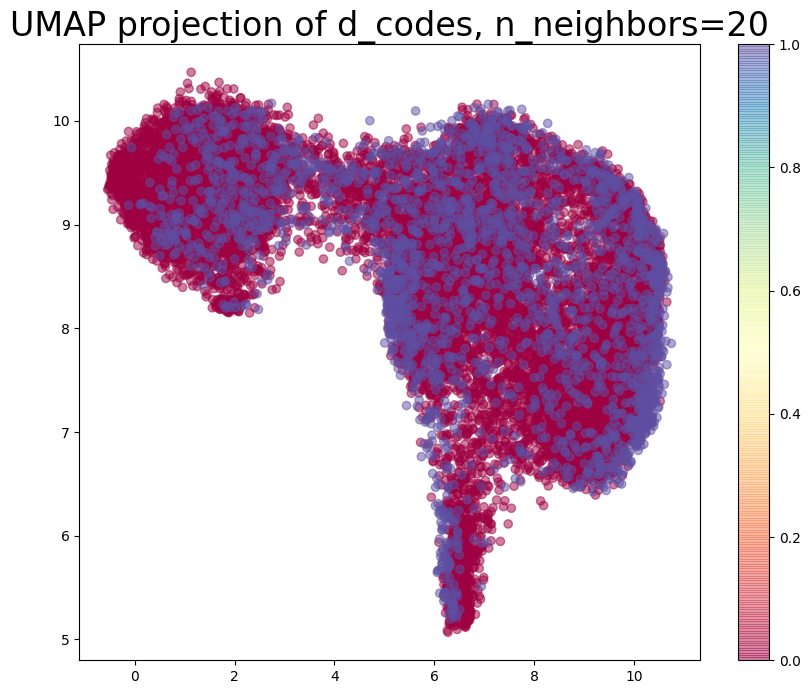

Running UMAP with n_neighbors=25


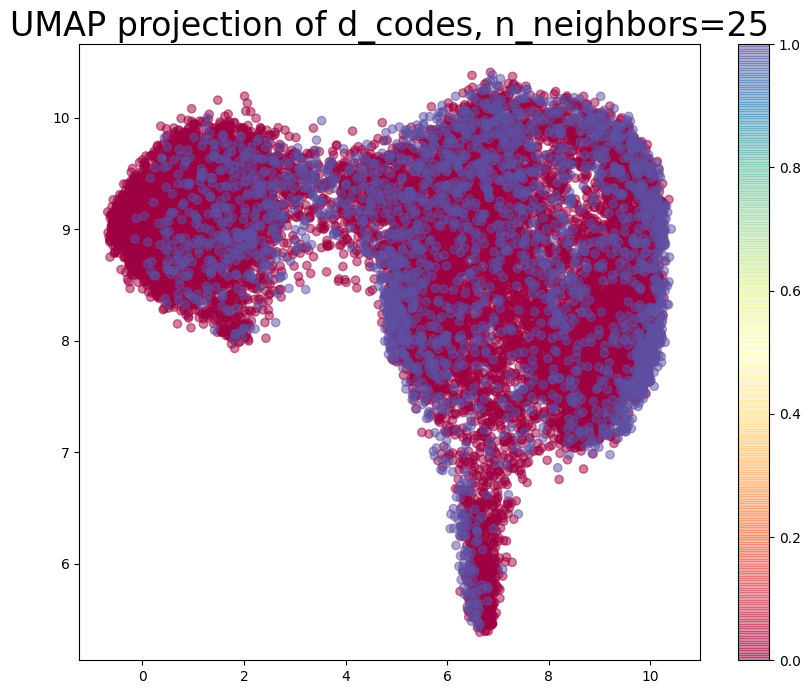

Running UMAP with n_neighbors=30


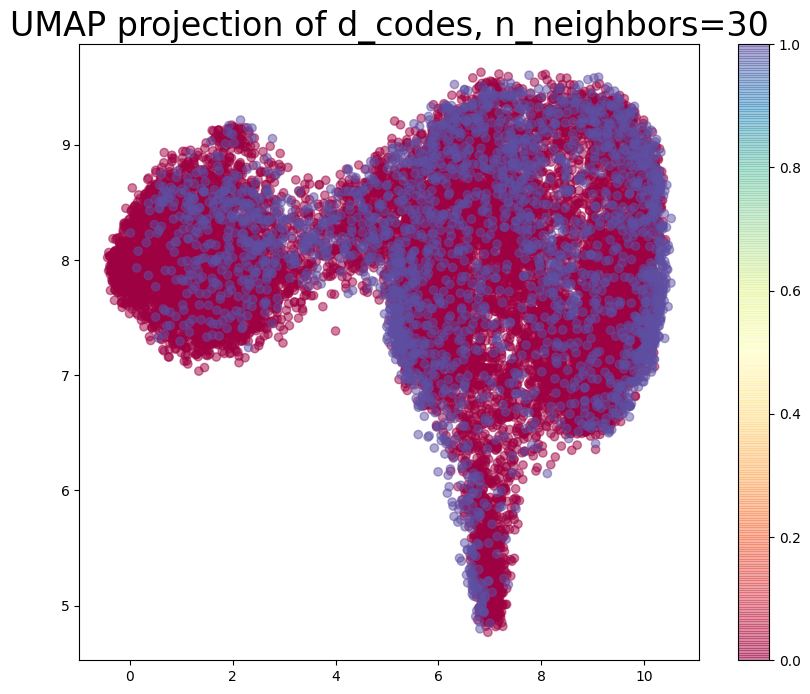

Running UMAP with n_neighbors=35


SystemError: CPUDispatcher(<function nn_descent at 0x7f5ad6f43f70>) returned a result with an error set

In [29]:
import numpy as np

# define the range of n_neighbors to sweep over
n_neighbors_range = np.arange(5, 55, 5)

for n_neighbors in n_neighbors_range:
    print(f"Running UMAP with n_neighbors={n_neighbors}")

    # create a UMAP reducer with the current n_neighbors
    reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors)

    # fit the reducer to the data and transform the data
    embedding = reducer.fit_transform(d_codes_np)

    # create a new figure for each plot
    plt.figure(figsize=(10, 8))

    # create a scatter plot
    scatter = plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=gt_labels_np, # color points by ground truth labels
        cmap='Spectral', # select color map
        alpha=0.5 # adjust transparency
    )

    # create a colorbar
    colorbar = plt.colorbar(scatter)

    # create a title that includes the current n_neighbors
    plt.title(f'UMAP projection of d_codes, n_neighbors={n_neighbors}', fontsize=24)

    # show the plot
    plt.show()


### Noise

In [62]:
ex_cell = torch.tensor(source[0][None]).to(device)
ex_cell.shape

torch.Size([1, 1000])

In [63]:
ex_cell

tensor([[3.0313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 3.0313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 3.0313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.7000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.0313, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [119]:
def cycle(batch, t, dt, fwd_cond, rvs_cond, cutoff=0.1):
    fwd_code = forward_diffuse_to_t(batch, t, dt, fwd_cond)
    recon = reverse_diffuse_from_t(fwd_code, t, dt, rvs_cond)
    zeroed_recon = np.where(np.abs(recon) < cutoff, 0, recon)
    return fwd_code, recon, zeroed_recon

def mse(batch, t, dt, fwd_cond, rvs_cond, cutoff=0.1):
    _, recon, zeroed_recon = cycle(batch, t, dt, fwd_cond, rvs_cond, cutoff=cutoff)
    return torch.mean((batch - torch.tensor(zeroed_recon).to(device))**2)

def test_cycle_consistency(batch, t, dt, fwd_cond, rvs_cond, cutoff=0.1):
    fwd_code, recon, zeroed_recon = cycle(batch, t, dt, fwd_cond, rvs_cond, cutoff=cutoff)
    try:
        assert torch.allclose(batch, torch.tensor(zeroed_recon).to(device), atol=0.1), f"Cycle consistency failed at t={t}"
    except:
        non_zero_gene_inds = torch.where(torch.abs(batch) > 0)[1]
        non_zero_recon_inds = np.where(np.abs(recon) > cutoff)[1]
        print(f"Non-zero genes at t={t}: {non_zero_gene_inds}")
        print(f"Non-zero recon at t={t}: {non_zero_recon_inds}")
        print(f'MSE at t={t}: {torch.mean((batch - torch.tensor(zeroed_recon).to(device))**2)}')
    

In [113]:
control_cond = torch.zeros([1]).int().to(device)
trametinib_cond = (torch.ones([1]).int() * 171).to(device)

In [117]:
test_cycle_consistency(ex_cell, 1.0, 0.01, fwd_cond=control_cond, rvs_cond=control_cond)

/tmp/ipykernel_402513/2219886959.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t_fwd = torch.tensor(x_t_fwd).float().to(device)


Non-zero genes at t=1.0: tensor([  0,  38,  73,  88,  97, 121, 122, 145, 162, 164, 201, 203, 225, 228,
        235, 254, 267, 285, 300, 339, 407, 436, 460, 473, 501, 535, 560, 664,
        682, 741, 757, 841, 870, 883, 910, 958], device='cuda:5')
Non-zero recon at t=1.0: [  0  21  25  26  37  38  46  47  48  54  60  65  73  78  87  88  97  99
 101 104 107 109 118 121 122 131 138 143 145 146 147 148 160 162 164 165
 169 172 177 184 187 191 194 195 201 202 203 219 221 225 226 228 233 234
 235 236 244 254 256 260 261 267 273 281 285 291 294 295 300 306 323 339
 353 359 376 382 388 402 407 432 436 438 439 450 458 460 461 473 484 487
 493 501 509 521 535 560 567 575 592 642 664 682 722 726 729 733 741 757
 765 770 797 818 821 836 837 841 848 857 870 883 910 918 933 958 988]
MSE at t=1.0: 0.017108961939811707


In [128]:
import matplotlib.pyplot as plt

# Define the dt values to test
dt_values = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]

# Compute the MSE for each dt value
mse_values = []
for dt in dt_values:
    mse_value = mse(ex_cell, 1.0, dt, control_cond, control_cond, cutoff=0.1)
    mse_values.append(mse_value.item())


/tmp/ipykernel_402513/2219886959.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t_fwd = torch.tensor(x_t_fwd).float().to(device)


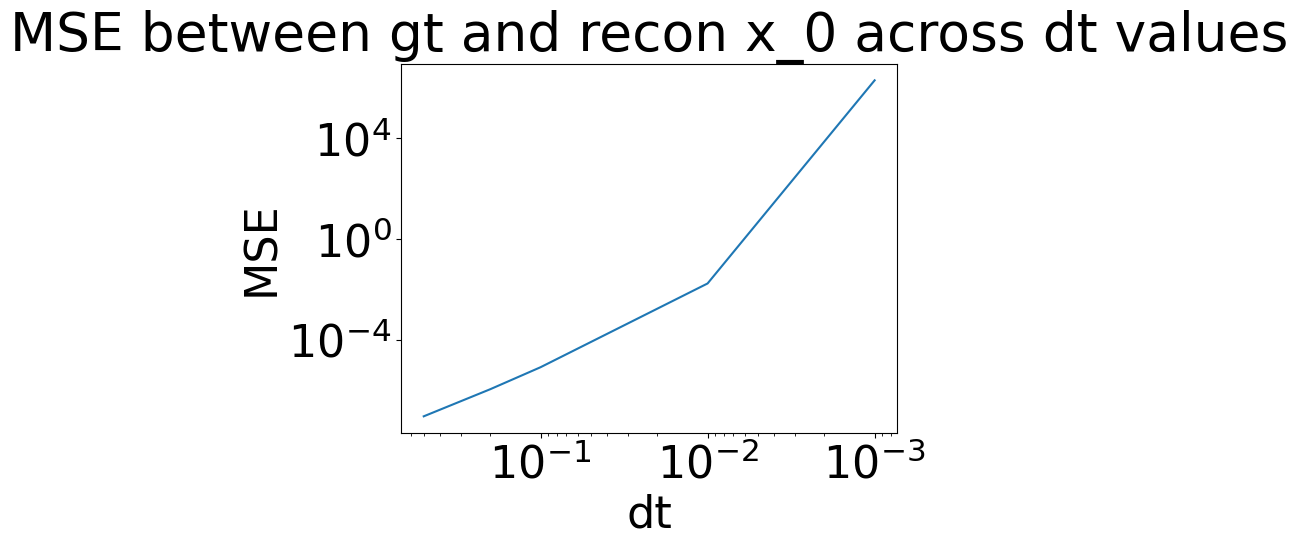

In [131]:
# Plot the MSE values
plt.plot(dt_values, mse_values)
plt.xlabel('dt')
plt.ylabel('MSE')

plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.title('MSE between gt and recon x_0 across dt values')

plt.show()

In [68]:
fwd_code = forward_diffuse_to_t(ex_cell, 0.5, 0.1, torch.zeros([1]).int().to(device))
# fwd_code

/tmp/ipykernel_402513/2219886959.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t_fwd = torch.tensor(x_t_fwd).float().to(device)


In [69]:
recon = reverse_diffuse_from_t(fwd_code, 0.5, 0.1, (torch.ones([1]).int() * 171).to(device))
recon

array([[ 3.00953555e+00,  9.34677664e-05,  2.44923867e-04,
        -1.48886349e-04,  1.07242726e-04, -5.53842547e-05,
        -5.82992216e-05, -2.50712386e-04, -6.88963337e-05,
         2.23014504e-05,  5.99288847e-04,  4.77593392e-04,
         1.29237305e-04,  2.02586874e-04,  2.26548826e-03,
         2.13050283e-03, -1.34179660e-04,  1.57892238e-04,
         1.09723769e-05,  9.15420242e-06,  2.20102444e-03,
         4.70643863e-03, -5.73689817e-04,  1.38901686e-03,
        -4.26093291e-04,  9.27131623e-05,  3.92872654e-03,
        -1.08916499e-03,  6.61603874e-04,  9.45586944e-05,
        -8.57908162e-06,  6.35643606e-04,  1.26364222e-03,
         1.80484354e-03,  1.27905310e-04, -3.64214648e-05,
        -5.83626388e-05,  5.38995489e-04,  3.02598166e+00,
        -1.42162596e-03,  8.90521798e-04, -2.06088834e-03,
         1.26480591e-04, -6.87823864e-04,  3.34759825e-05,
         9.40416940e-05,  5.63685223e-03,  5.07836416e-03,
         2.60192901e-03,  3.46167013e-04,  6.04770612e-0

In [70]:
non_zero_gene_inds = torch.where(ex_cell > 0)
non_zero_gene_inds

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:5'),
 tensor([  0,  38,  73,  88,  97, 121, 122, 145, 162, 164, 201, 203, 225, 228,
         235, 254, 267, 285, 300, 339, 407, 436, 460, 473, 501, 535, 560, 664,
         682, 741, 757, 841, 870, 883, 910, 958], device='cuda:5'))

In [71]:
non_zero_recon_inds = np.where(recon > 0.01)
non_zero_recon_inds

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  0,  38,  73,  88,  97, 121, 122, 145, 162, 164, 201, 203, 225,
        228, 235, 254, 267, 285, 300, 339, 407, 436, 460, 473, 501, 535,
        560, 664, 682, 741, 757, 841, 870, 883, 910, 958]))

In [72]:
non_zero_recon_inds = np.where(recon > 0.01)
non_zero_recon_inds

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  0,  38,  73,  88,  97, 121, 122, 145, 162, 164, 201, 203, 225,
        228, 235, 254, 267, 285, 300, 339, 407, 436, 460, 473, 501, 535,
        560, 664, 682, 741, 757, 841, 870, 883, 910, 958]))

In [27]:
zeroed_recon = np.where(recon > 0.1, recon, 0)
zeroed_recon

array([[3.0014577, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 3.0305612, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 3.0270197, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.      

In [28]:
all_recons = np.concatenate(recons, axis=0)

In [29]:
all_recons.shape

(4096, 1000)

In [30]:
target = datasets.train.target.adata.X
target.shape

(2621, 1000)

In [45]:
def compute_mmd_on_selected_genes(recon, target, selected_genes, gammas):
    return compute_mmd_loss(recon[:, selected_genes], target[:, selected_genes], gammas)

In [31]:
gt_xs = torch.cat([x[0] for x in gts], axis=0).cpu().numpy()

In [32]:
np.mean((all_recons - gt_xs)**2)

6.6915686e-06

In [ ]:
mmd_loss = compute_mmd_on_selected_genes(all_recons, target, gene_idxs, gammas)

In [53]:
mmd_loss = compute_mmd_on_selected_genes(all_recons, source, gene_idxs, gammas)

In [35]:
mmd_loss

0.018866840498521924

## Noise

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_marker_gene_expression(all_gts, target, all_recon, all_uncond_recons, gene_idxs, gene_names, cutoff=0.1, font_size=32, fig_title='Top 5 Marker Gene Expression Histograms for Trametinib Perturbation'):
    # Prepare figure and axes
    fig, axs = plt.subplots(len(gene_idxs), 4, figsize=(50, 40))
    plt.rcParams.update({'font.size': font_size})  # Update font size

    for i in range(len(gene_idxs)):
        # Extract values
        source_values = all_gts[:, gene_idxs[i]]
        target_values = target[:, gene_idxs[i]]
        recon_values = all_recon[:, gene_idxs[i]]
        uncond_recon_values = all_uncond_recons[:, gene_idxs[i]]
        # latent_iden_recon_values = all_latent_identities[:, gene_idxs[i]]

        # Create subplots
        axs[i][0].hist(source_values[source_values > cutoff])
        axs[i][0].set_title('Source')
        axs[i][1].hist(target_values[target_values > cutoff])
        axs[i][1].set_title('Target')
        axs[i][2].hist(recon_values[recon_values > cutoff])
        axs[i][2].set_title('Cond Recon')
        axs[i][3].hist(uncond_recon_values[uncond_recon_values > cutoff])
        axs[i][3].set_title('Uncond Recon')
        # axs[i][4].hist(latent_iden_recon_values[latent_iden_recon_values > cutoff])
        # axs[i][4].set_title('Latent Iden Recon')

        axs[i][0].set_ylabel(gene_names[i])

    # Adjust figure and show
    fig.subplots_adjust(top=0.95)  # Adjust as needed
    fig.suptitle(fig_title)
    plt.show()


In [40]:
all_uncond_recons = np.concatenate(uncond_recons, axis=0)

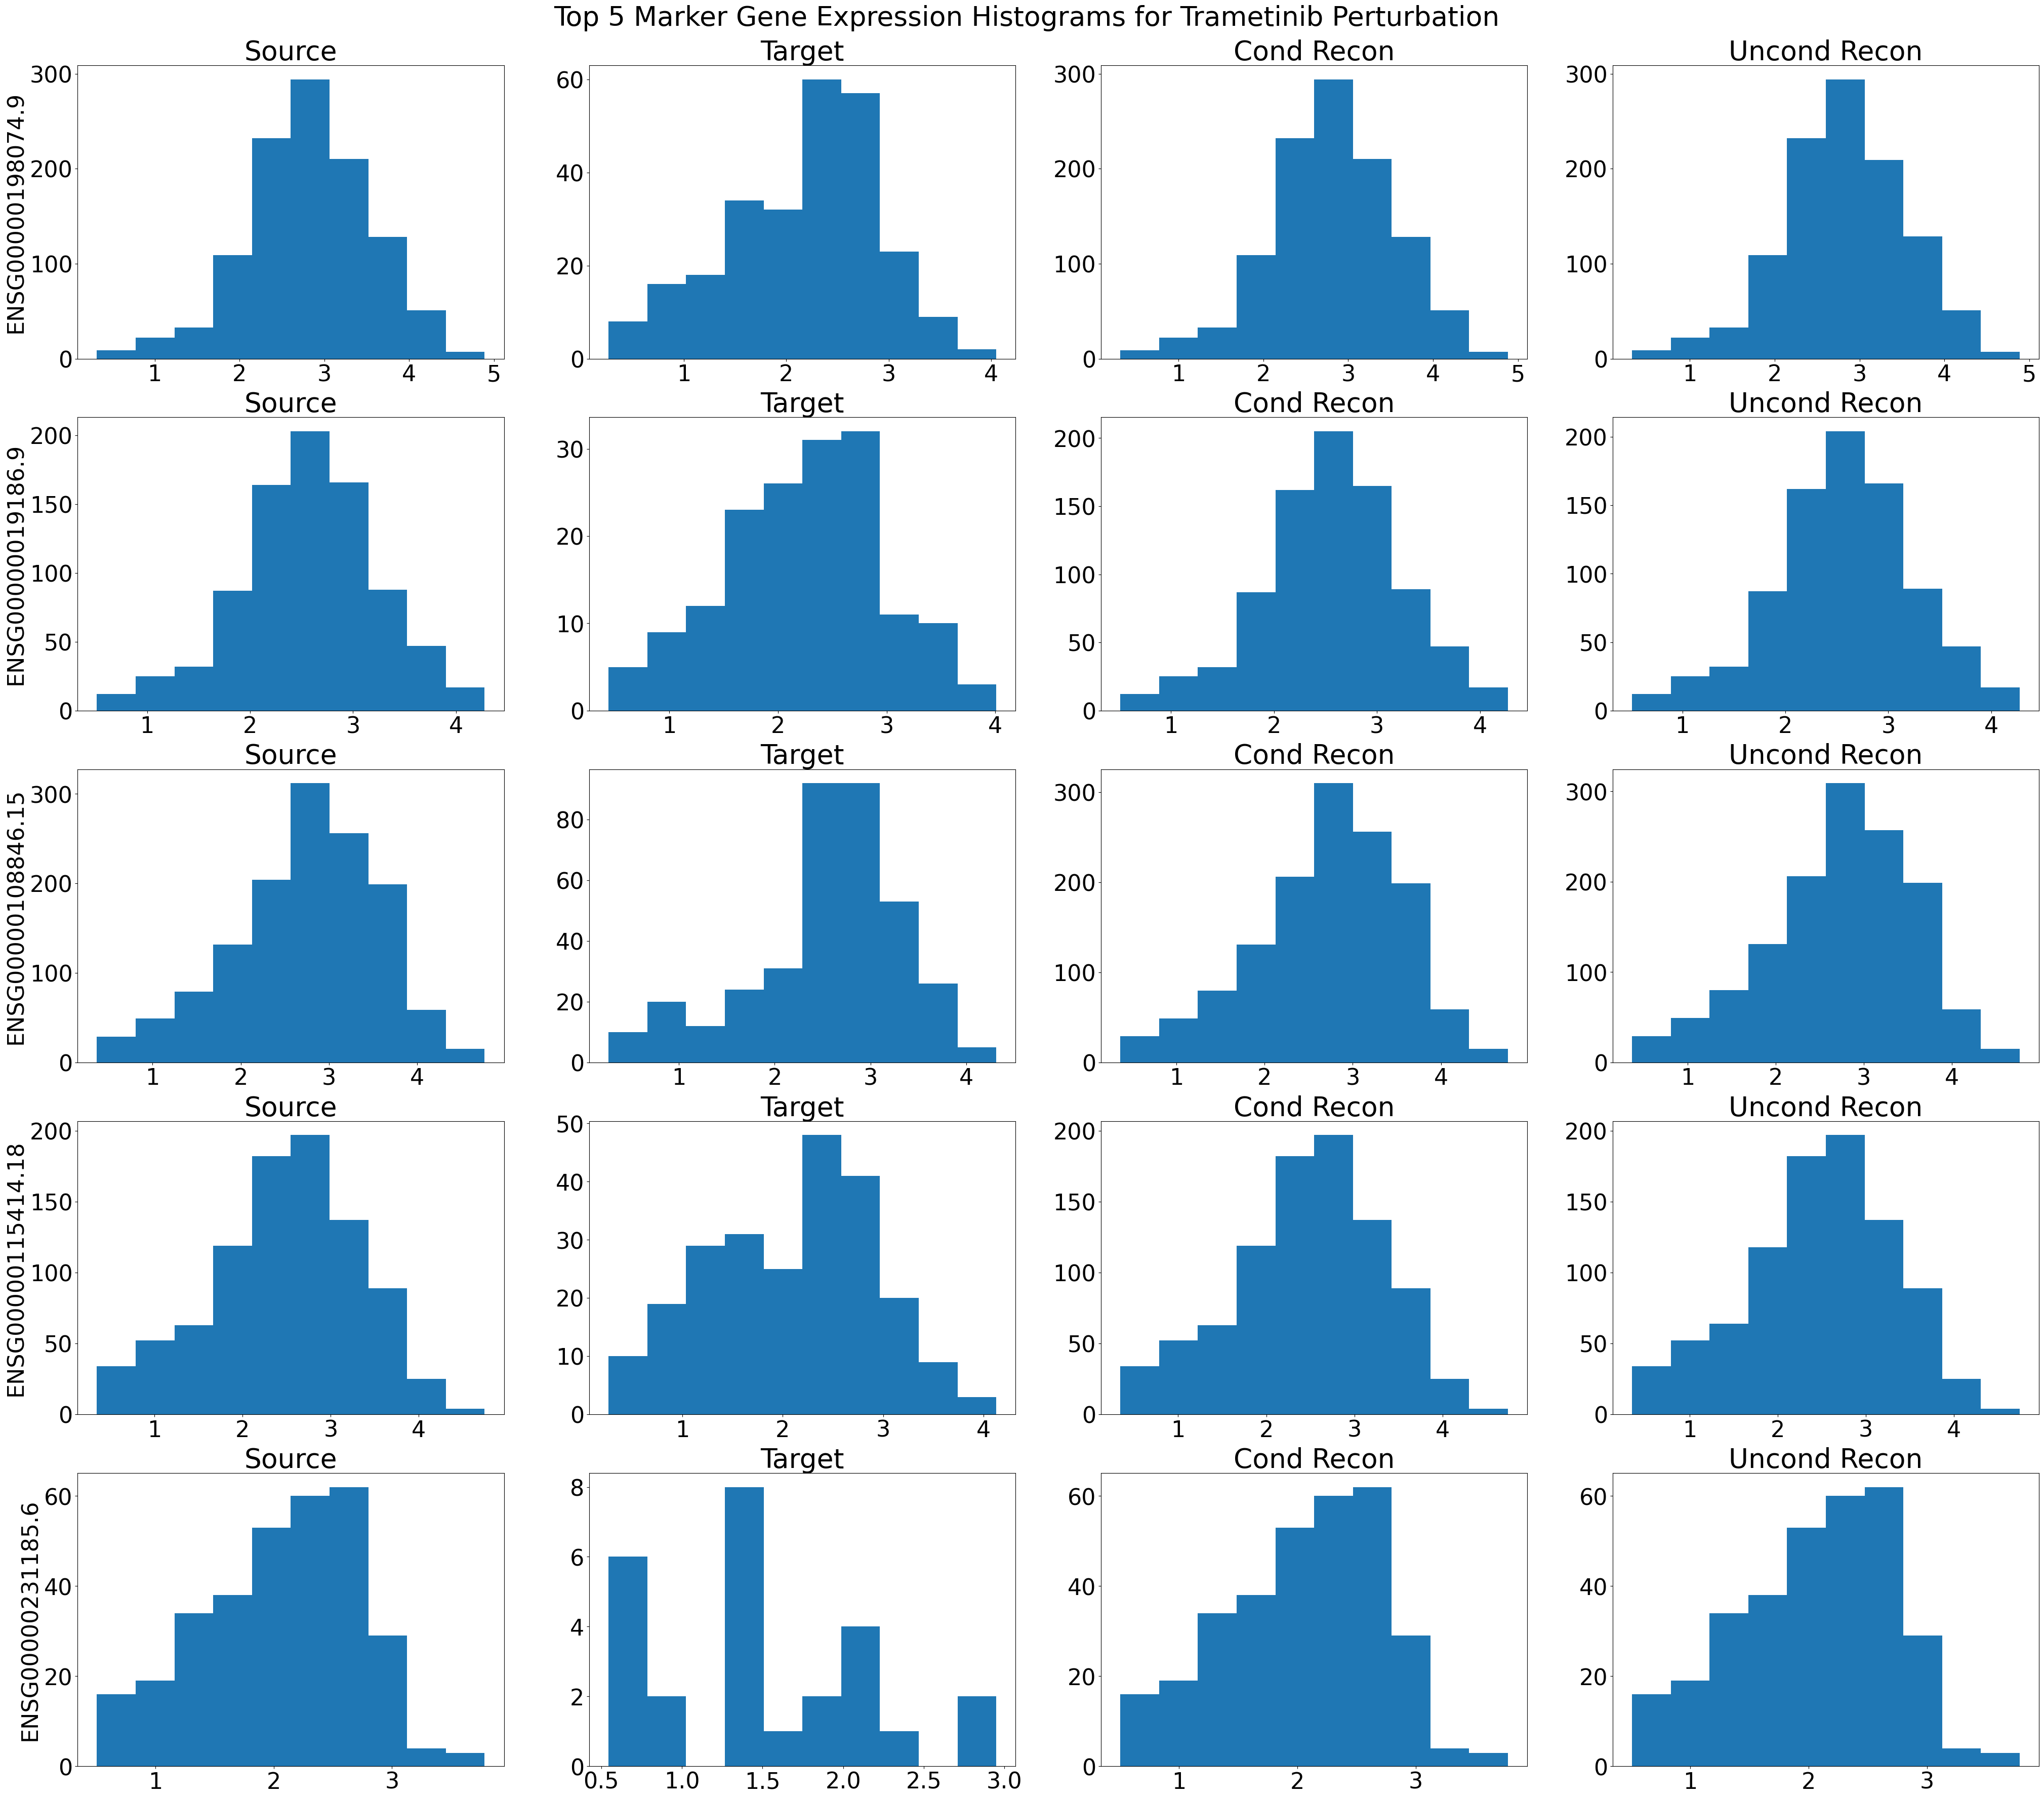

In [41]:
plot_marker_gene_expression(gt_xs, target, all_recons, all_uncond_recons, gene_idxs[:5], sel_mg[:5])